In [230]:
import torch
import numpy as np
from razdel import tokenize
from torchtext.data.utils import get_tokenizer

# create dataframe

In [231]:
import os
from razdel import sentenize
from data_helpers import *
path_to_raw_data = os.getcwd() + "/data/"
path_to_sources = os.getcwd() + "/sources/"

bulgakov_text = get_raw_text_from_dir(path_to_raw_data + "bulgakov/")
gogol_text = get_raw_text_from_dir(path_to_raw_data + "gogol/")
bul_sentences = filter_and_sentenize(bulgakov_text, sentenize)
gog_sentences = filter_and_sentenize(gogol_text, sentenize)
bul_df = create_datadarame(bul_sentences, 0)
gog_df = create_datadarame(gog_sentences, 1)

bul_df.to_csv(path_to_sources + "bul_df.csv")
gog_df.to_csv(path_to_sources + "gog_df.csv")

# create train/test items

In [232]:
import os
import pandas as pd
from data_helpers import *
path_to_sources = os.getcwd() + "/sources/"
bul_df = pd.read_csv(path_to_sources + "bul_df.csv")
gog_df= pd.read_csv(path_to_sources + "gog_df.csv")
bul_df = bul_df[["sentence", "label"]]
gog_df = gog_df[["sentence", "label"]]
bul_df = bul_df.iloc[:int(len(bul_df) * 0.6)]

merged_df = pd.merge(bul_df, gog_df, how='outer')
merged_df = merged_df.sample(frac=1)
all_items = merged_df.values

train_items, val_items, test_items = train_val_sliced(all_items, 0.8, 0.1)

In [233]:
len(train_items)

13029

<h2>text processing pipelines</h2>

In [234]:
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import pymorphy2

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

def ntlk_preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token.replace('\n', ' ').replace(' ', '') for token in tokens]
    tokens = [token for token in tokens if len(token) > 0]
              #and token not in russian_stopwords
              #and token != " "]
              #and token.strip() not in punctuation]
    
    return tokens

def cut_sentence(substrings, min_length, max_length):
    return [t for t in substrings if len(t) > min_length and len(t) < max_length]

def normalize(sentence, tokenizer, min_length=0, max_length=float("inf")):
    tokenized = list(tokenizer(sentence))
    tokenized = [morph.parse(t.text)[0].normal_form for t in tokenized]
    tokenized = cut_sentence(tokenized, min_length, max_length)
    return tokenized

In [235]:
from collections import Counter, OrderedDict
sentences = [item[0] for item in np.concatenate((train_items,val_items))]
sentences_by_tokens = [[w for w in ntlk_preprocess_text(s)] for s in sentences]
tokens = sum(sentences_by_tokens, [])
counter = Counter(tokens)

In [236]:
from torchtext.vocab import vocab
import math 
#pick tokens for vocabulary
vocab_size = 3000
most_common_tokens = counter.most_common(vocab_size)[200:]
sentence_idf_count = 10000

In [237]:
def make_tf_idf(token_count, doc_count):
    tf = token_count / len(tokens)
    if doc_count == 0:
        return 1
    df = math.log(sentence_idf_count / doc_count)
    return (tf * df + 0.5)

def make_tf(token_count):
    return token_count / len(tokens)

def get_count(token):
    return len([_ for sentence in tokens[:sentence_idf_count] if token in sentence])    

In [238]:
#mapping from token to value in bow vector
#token_to_value_tfidf = dict([(token, make_tf_idf(counter[token],get_count(token))) for (token, count) in most_common_tokens])
token_to_value_tf = dict([(token, 1) for (token, count) in most_common_tokens])
#create vocabulary
bow_vocab = vocab(OrderedDict(most_common_tokens), specials=["<unk>"])
bow_vocab.set_default_index(bow_vocab["<unk>"])

In [239]:
import torch
import numpy as np
from torch.utils.data import Dataset

class BowTextDataset(Dataset):
    
    def __init__(self, items, vocabulary, token_to_value, tokenizer):
        self.items = items
        self.tokenizer = tokenizer
        self.vocabulary = vocabulary
        self.token_to_value = token_to_value
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        batch = self.items[idx]
        text_list = []
        label_list = []
        #for (_text, _label) in batch:
        (_text, _label) = batch
        processed_text = torch.tensor(self.bow_pipeline(_text), dtype=torch.float32)
        text_list.append(processed_text)
        text_list = torch.stack(text_list).sum(1) 
        label_list.append(_label)
        label_list = torch.tensor(label_list, dtype=torch.int64)
        return processed_text.to(self.device), label_list.to(self.device)

    def bow_pipeline(self, sentence):
        token_idx_to_value = []
        for token in self.tokenizer(sentence):
            if token in self.token_to_value.keys():
                token_idx_to_value.append((self.vocabulary[token], self.token_to_value[token]))
        indeces = [item[0] for item in token_idx_to_value]
        values = [item[1] for item in token_idx_to_value]
        bow_vector = np.zeros((1,len(self.vocabulary)))
        bow_vector[0][indeces] = values
        return bow_vector
    
#create dataset
train_ds = BowTextDataset(train_items, bow_vocab, token_to_value_tf, ntlk_preprocess_text)
val_ds = BowTextDataset(val_items, bow_vocab, token_to_value_tf, ntlk_preprocess_text)

# models

In [170]:
import torch.nn as nn

class TextClassificationModel(nn.Module):

    def __init__(self, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text_bow):
        return self.fc(text_bow)

In [171]:
import torch.nn as nn
class TextClassificationModel2Layer(nn.Module):

    def __init__(self, embed_dim, num_class):
        super(TextClassificationModel2Layer, self).__init__()
        self.fc1 = nn.Linear(embed_dim, 10000)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10000, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text_bow):
        fc1_out = self.fc1(text_bow)
        relu_out = self.relu(fc1_out)
        return self.fc2(relu_out)

# train

In [240]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (text, label) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text).sum(1)
        label = label.sum(1)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5d}/{:5d} batches '
            #      '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
            #                                  total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
            

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            predicted_label = model(text).sum(1)
            label = label.sum(1)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [241]:
from torch.utils.data import DataLoader
import time
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 5  # epoch
LR = 5  # learning rate

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
model = TextClassificationModel(len(bow_vocab), 2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

total_accu = None
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time:  6.76s | valid accuracy    0.819 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  6.34s | valid accuracy    0.818 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  6.34s | valid accuracy    0.843 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  6.34s | valid accuracy    0.840 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  7.21s | valid accuracy    0.840 
-----------------------------------------------------------


In [53]:
def reset_weights(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

In [31]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import time

In [175]:
#Kfold
k_folds = 3
BATCH_SIZE = 32
EPOCHS = 3  # epoch
LR = 5  # learning rate

total_accu = None
total_fold_accuarcy = 0

kfold=KFold(n_splits=k_folds,shuffle=True)
for fold,(train_idx,val_idx) in enumerate(kfold.split(train_items)):
    train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)
    model = TextClassificationModel(len(bow_vocab), 2)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        train(train_dataloader)
        accu_val = evaluate(valid_dataloader)
        if total_accu is not None and total_accu > accu_val:
            scheduler.step()
        else:
            total_accu = accu_val
        
        total_fold_accuarcy += total_accu
        print('-' * 25 + f"fold {fold}" + '-' * 25)
        print('| end of epoch {:3d} | time: {:5.2f}s | '
              'valid accuracy {:8.3f} '.format(epoch,
                                               time.time() - epoch_start_time,
                                               accu_val))
        print('-' * 59)
print(f"total accuracy {total_fold_accuarcy / (k_folds * EPOCHS)}") 

-------------------------fold 0-------------------------
| end of epoch   1 | time:  9.75s | valid accuracy    0.800 
-----------------------------------------------------------
-------------------------fold 0-------------------------
| end of epoch   2 | time:  9.52s | valid accuracy    0.795 
-----------------------------------------------------------
-------------------------fold 0-------------------------
| end of epoch   3 | time:  9.55s | valid accuracy    0.838 
-----------------------------------------------------------
-------------------------fold 1-------------------------
| end of epoch   1 | time:  9.51s | valid accuracy    0.807 
-----------------------------------------------------------
-------------------------fold 1-------------------------
| end of epoch   2 | time:  9.52s | valid accuracy    0.811 
-----------------------------------------------------------
-------------------------fold 1-------------------------
| end of epoch   3 | time:  9.71s | valid accuracy   

# Evaluate 

In [298]:
path_to_raw_data = os.getcwd() + "/data/"
path_to_sources = os.getcwd() + "/sources/"

bulgakov_text = get_raw_text_from(path_to_raw_data + "subachie_serdtse.txt")
gogol_text1 = get_raw_text_from(path_to_raw_data + "zapiski.txt")
gogol_text2 = get_raw_text_from(path_to_raw_data + "revizor.txt")
gogol_text = " ".join([gogol_text1])
bul_sentences = filter_and_sentenize(bulgakov_text, sentenize)
gog_sentences = filter_and_sentenize(gogol_text, sentenize)
bul_df = create_datadarame(bul_sentences, 0)
gog_df = create_datadarame(gog_sentences, 1)
bul_df.to_csv(path_to_sources + "bul_df_test.csv")
gog_df.to_csv(path_to_sources + "gog_df_test.csv")

364831

In [300]:
bul_df_test = pd.read_csv(path_to_sources + "bul_df_test.csv")
gog_df_test= pd.read_csv(path_to_sources + "gog_df_test.csv")
bul_df_test = bul_df_test[["sentence", "label"]]
gog_df_test = gog_df_test[["sentence", "label"]]
merged_df_test = pd.merge(bul_df_test, gog_df_test, how='outer')
merged_df_test = merged_df_test.sample(frac=1)
test_items = merged_df_test.values

In [302]:
BATCH_SIZE = 32
test_ds = BowTextDataset(test_items, bow_vocab, token_to_value_tf, ntlk_preprocess_text)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)
evaluate(test_dataloader)

0.6449456975772765

<h2>Save results</h2>

In [18]:
def append_log(embedding_desc, model, learning_desc, validation):
    date_time = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
    data = [[embedding_desc, model.__str__(), learning_desc, validation, date_time]]
    df = pandas.read_csv(dir_path + "results.csv")
    df.loc[len(df.index)] = [''] + data[0]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(dir_path + "results.csv")

In [ ]:
m = nn.Linear(vocab_size, 2)
#input = torch.tensor(bow_tensor_bul[0:1].clone().detach(), dtype=torch.float32)
output = m(bow_tensor_bul[0:5])
print(output)
print(output.size())

# Reslut plot 

In [119]:
equal = predicted[:100].argmax(1).numpy() != np.array(true[:100])

NameError: name 'predicted' is not defined

In [ ]:
len(test_items)

In [ ]:
softmax(model(text))

In [19]:
items_to_eval = train_items[:1000]
col = collate_batch_bow(items_to_eval)
true = [item[1] for item in items_to_eval]
softmax = nn.Softmax(dim=1)
result = model(col[0])
predicted = softmax(result)

In [20]:
data_to_draw = torch.tensor([p[0] - p[1] if t == 0 else p[1] - p[0] for t, p in zip(true, predicted)])
data_to_draw = data_to_draw.numpy().tolist()

In [ ]:
np.arange(100, step=10)

<BarContainer object of 1000 artists>

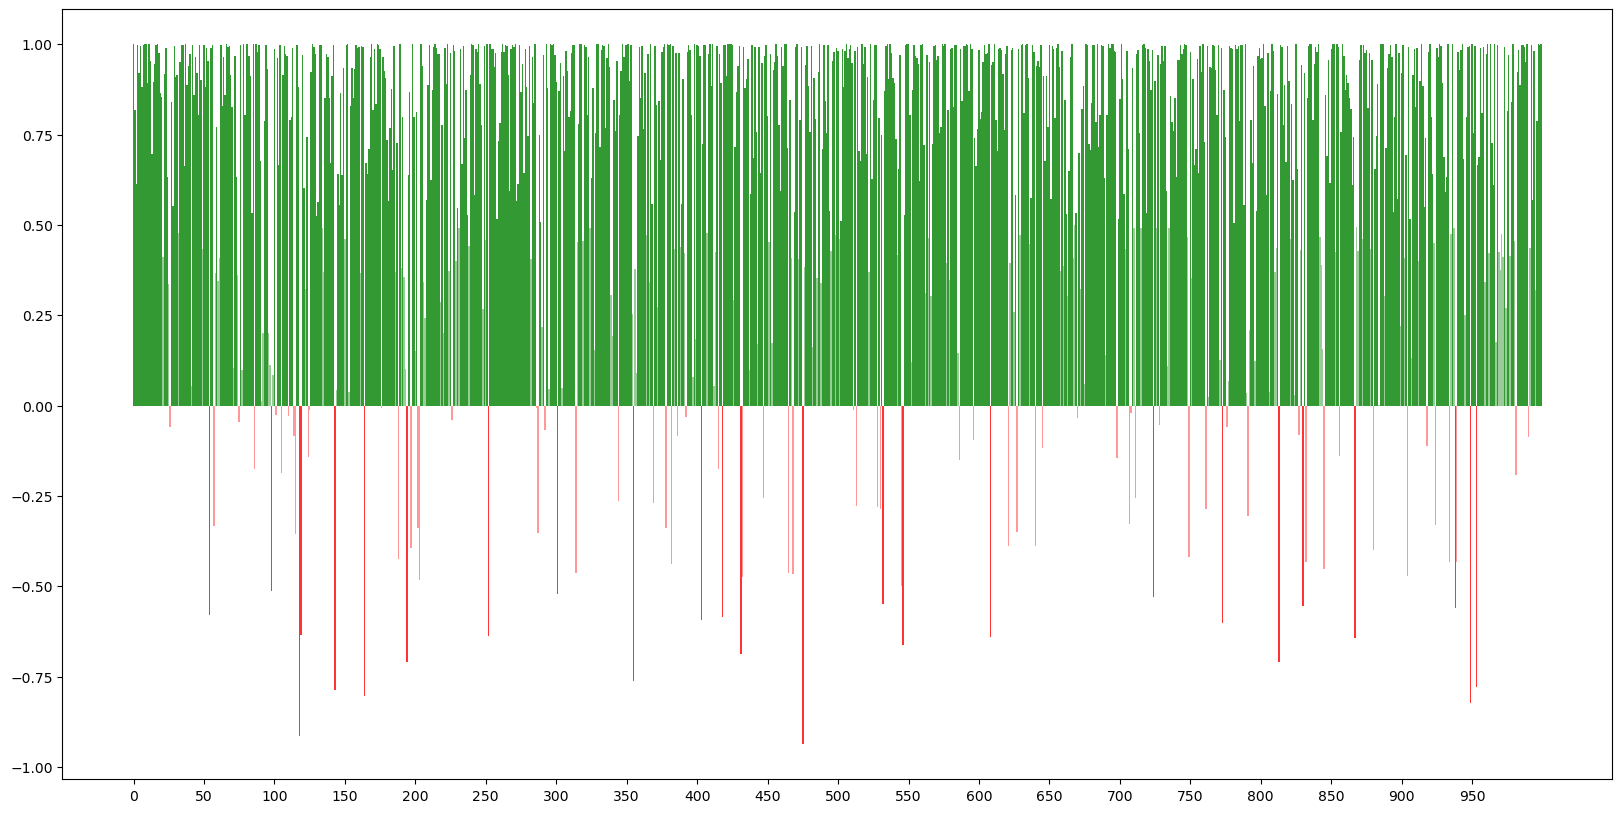

In [22]:
import numpy as np
import matplotlib.pyplot as plt

rang = range(len(data_to_draw))
negative_data_min = [x if x < 0 and x >= -0.5 else 0 for x in data_to_draw]
negative_data_max = [x if x < -0.5 else 0 for x in data_to_draw]
positive_data_min = [x if x > 0 and x <= 0.5 else 0 for x in data_to_draw]
positive_data_max = [x if x > 0.5 else 0 for x in data_to_draw]

fig = plt.figure(figsize=(20, 10), dpi=100)
plt.xticks(np.arange(len(data_to_draw), step=50))
ax = plt.subplot(111)
ax.bar(rang, negative_data_min, width=1, color='r', alpha=0.4)
ax.bar(rang, negative_data_max, width=1, color='r', alpha=0.8)
ax.bar(rang, positive_data_min, width=1, color='g', alpha=0.4)
ax.bar(rang, positive_data_max, width=1, color='g', alpha=0.8)


In [ ]:
mu, sigma = 100, 15
x = mu + sigma * np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(x, 6, density=True, facecolor='g', alpha=1)

plt.xlabel('Inputs')
plt.ylabel('Distance')
plt.title('BoW + FF 1')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([30, 500, -2, 2])
plt.grid(True)
plt.show()

In [ ]:
gog_text = "Не только в вашей стране, но и в других странах будут сочинять подражания его пьесам и писать переделки этих пьес. Ученые различных стран напишут подробные исследования его произведений и шаг за шагом постараются проследить его таинственную жизнь. Они докажут вам, что этот человек, который сейчас у вас в руках подает лишь слабые признаки жизни, будет влиять на многих писателей будущих столетий, в том числе на таких, неизвестных вам, но известных мне, как соотечественники мои Грибоедов, Пушкин и Гоголь."

In [ ]:
gog_input = collate_batch_bow([(gog_text, 0)])